In [3]:
import pickle
import sys

import ray
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import healpy as hp
import os

import GCE.gce
gce = GCE.gce.Analysis()
gce.load_params("../parameter_files/parameters.py")

2023-01-16 22:39:12.133179: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-16 22:39:12.133264: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


2023-01-16 22:39:26.429524: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 22:39:26.432059: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-01-16 22:39:26.518948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-16 22:39:26.518989: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.515GHz coreCount: 14 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 178.84GiB/s
202

Number of devices: 1
Loading parameters from '../parameter_files/parameters.py'...
Loading parameters: ['Edep' 'comb' 'data' 'gen' 'mod' 'nn' 'plot' 'train' 'tt']


In [4]:
ray_settings = {"num_cpus": 4}  # select the number of CPUs here
#gce.generate_template_maps(ray_settings, n_example_plots=5, job_id=0)

#gce.combine_template_maps(save_filenames=True, do_combine=True)

In [5]:
gce.build_pipeline()

2023-01-16 22:40:27.562826: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-16 22:40:27.695833: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2496005000 Hz


Input pipeline successfully built.


In [6]:
row=len(gce.p.Edep.keys())-2
col=len(gce.p.data["Ebins"])-1
print(col)

10


In [7]:
samples = gce.datasets["train"].get_samples(200)
data, labels = samples["data"], samples["label"]

2023-01-16 22:40:30.963522: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84203520 exceeds 10% of free system memory.
2023-01-16 22:40:31.123585: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84203520 exceeds 10% of free system memory.


Training: End of epoch!


2023-01-16 22:40:31.228543: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84203520 exceeds 10% of free system memory.
2023-01-16 22:40:31.390285: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84203520 exceeds 10% of free system memory.


Training: End of epoch!
Training: End of epoch!


Training: End of epoch!


2023-01-16 22:40:31.531247: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84203520 exceeds 10% of free system memory.


Training: End of epoch!
Training: End of epoch!
Training: End of epoch!
Training: End of epoch!
Training: End of epoch!
Training: End of epoch!
Training: End of epoch!
Training: End of epoch!
Training: End of epoch!


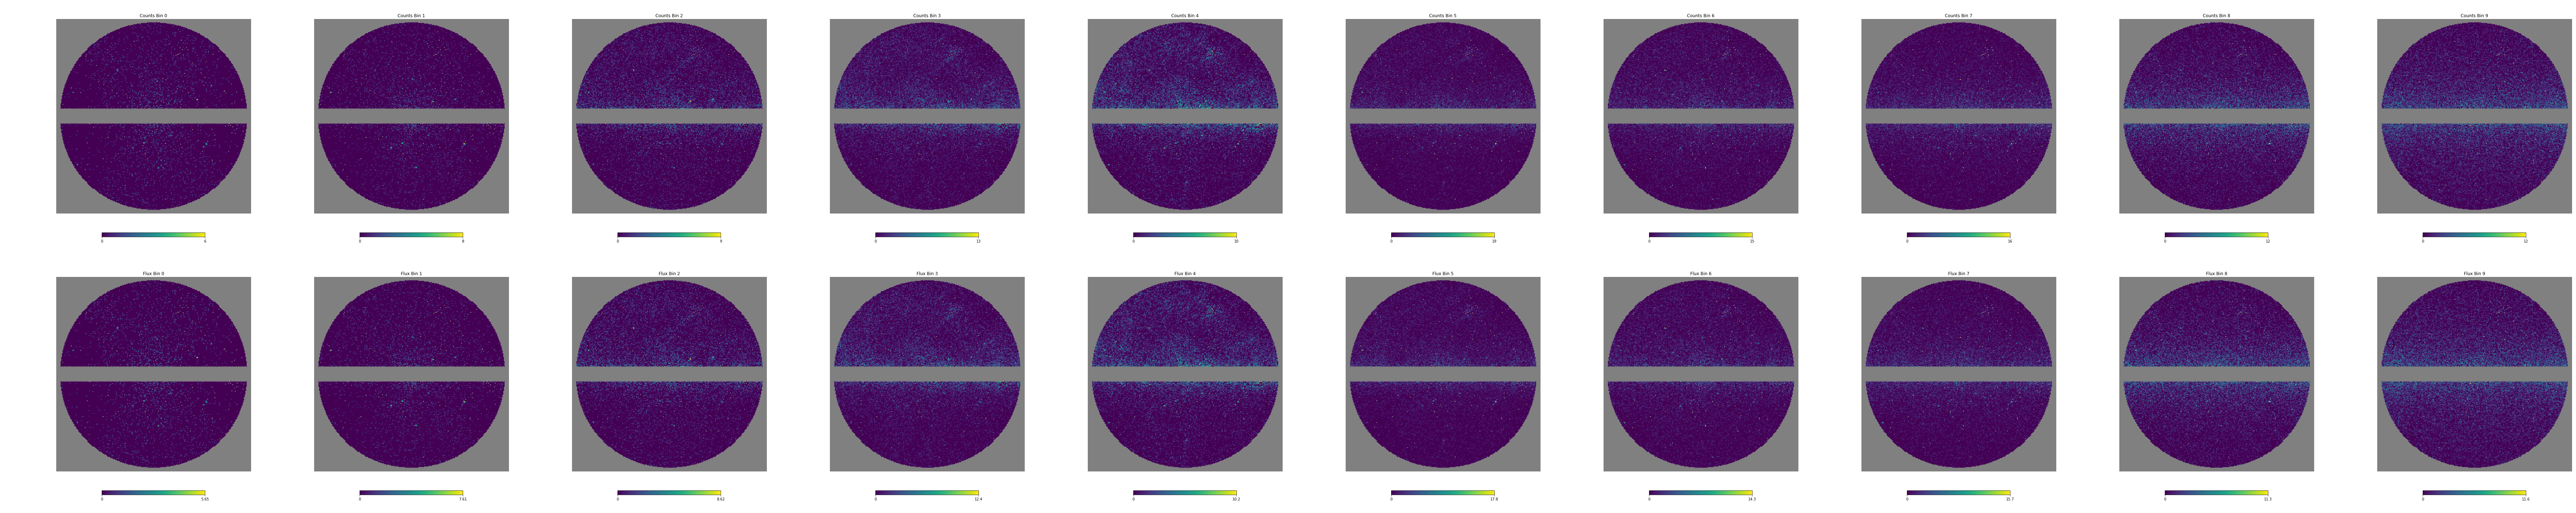

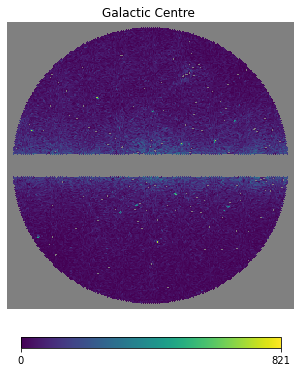

In [8]:
samples = gce.datasets["train"].get_samples(200)
data, labels = samples["data"], samples["label"]
# NOTE: the maps are stored in NEST format
map_to_plot = 0 #index of which map is plotted
r = gce.p.data["outer_rad"] + 1
#insert the params
fig, ax= plt.subplots(2,col,figsize = (100,20))

subplot=1
[axi.set_axis_off() for axi in ax.ravel()]
plt.tight_layout()
for Ebin in range(0,len(gce.p.data["Ebins"])-1):

    hp.cartview(gce.decompress(data[map_to_plot,:,Ebin] * gce.template_dict["rescale_compressed"][:,Ebin], fill_value=np.nan), nest=True,
                 lonra=[-r, r], latra=[-r, r], sub=(2,col,subplot), title='Counts Bin ' + str(Ebin))

    hp.cartview(gce.decompress(data[map_to_plot,:,Ebin], fill_value=np.nan), nest=True,
                 lonra=[-r, r], latra=[-r, r], sub=(2,col,col+subplot), title='Flux Bin ' + str(Ebin))
    subplot+=1

plt.show()

hp.cartview(gce.decompress(data[map_to_plot,:,:].sum(1) * gce.template_dict["rescale_compressed"][:,:].sum(1), fill_value=np.nan), nest=True,
                 lonra=[-r, r], latra=[-r, r],  title='Galactic Centre ')
plt.savefig("Galactic Centre")
plt.show()
print(r)

In [9]:
unique,counts=np.unique(gce.decompress(data[map_to_plot,:,0] * gce.template_dict["rescale_compressed"][:,0]),return_counts=True)
print(str(unique[0]) + " " + str(counts[0]))

unique,counts=np.unique(gce.decompress(data[map_to_plot,:,9] * gce.template_dict["rescale_compressed"][:,9]),return_counts=True)
print(str(unique[0]) + " " + str(counts[0]))


0.0 783976
0.0 768470


In [10]:
map_bin_0=gce.decompress(data[map_to_plot,:,0] * gce.template_dict["rescale_compressed"][:,0])
map_bin_0_mask=map_bin_0==0
map_bin_9=gce.decompress(data[map_to_plot,:,9] * gce.template_dict["rescale_compressed"][:,9])
map_bin_9_mask=map_bin_9==0

In [11]:
map_bin_0.shape

(786432,)

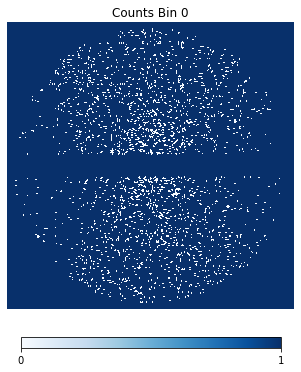

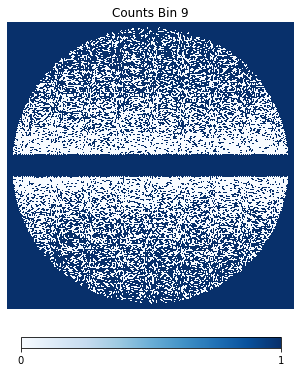

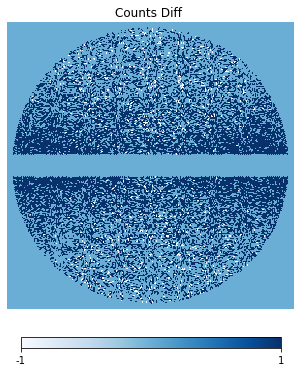

In [12]:
hp.cartview(map_bin_0_mask, nest=True,
                 lonra=[-r, r], latra=[-r, r], title='Counts Bin ' + str(0), cmap="Blues")
plt.show()
hp.cartview(map_bin_9_mask, nest=True,
                 lonra=[-r, r], latra=[-r, r], title='Counts Bin ' + str(9), cmap="Blues")
plt.show()
mask_diff=map_bin_0_mask.astype("int")-map_bin_9_mask.astype("int")

hp.cartview(mask_diff, nest=True,
                 lonra=[-r, r], latra=[-r, r], title='Counts Diff ', cmap="Blues")
plt.show()

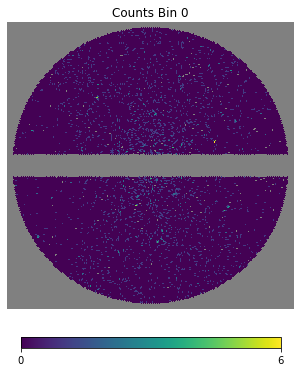

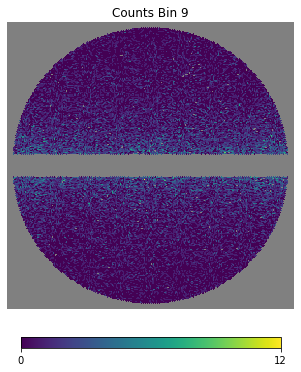

In [13]:
hp.cartview(gce.decompress(data[map_to_plot,:,0] * gce.template_dict["rescale_compressed"][:,0], fill_value=np.nan), nest=True,
                 lonra=[-r, r], latra=[-r, r], title='Counts Bin ' + str(0))
plt.show()
hp.cartview(gce.decompress(data[map_to_plot,:,9] * gce.template_dict["rescale_compressed"][:,9], fill_value=np.nan), nest=True,
                 lonra=[-r, r], latra=[-r, r], title='Counts Bin ' + str(9))
plt.show()

In [14]:
gce.template_dict["rescale_compressed"].shape

(32892, 10)

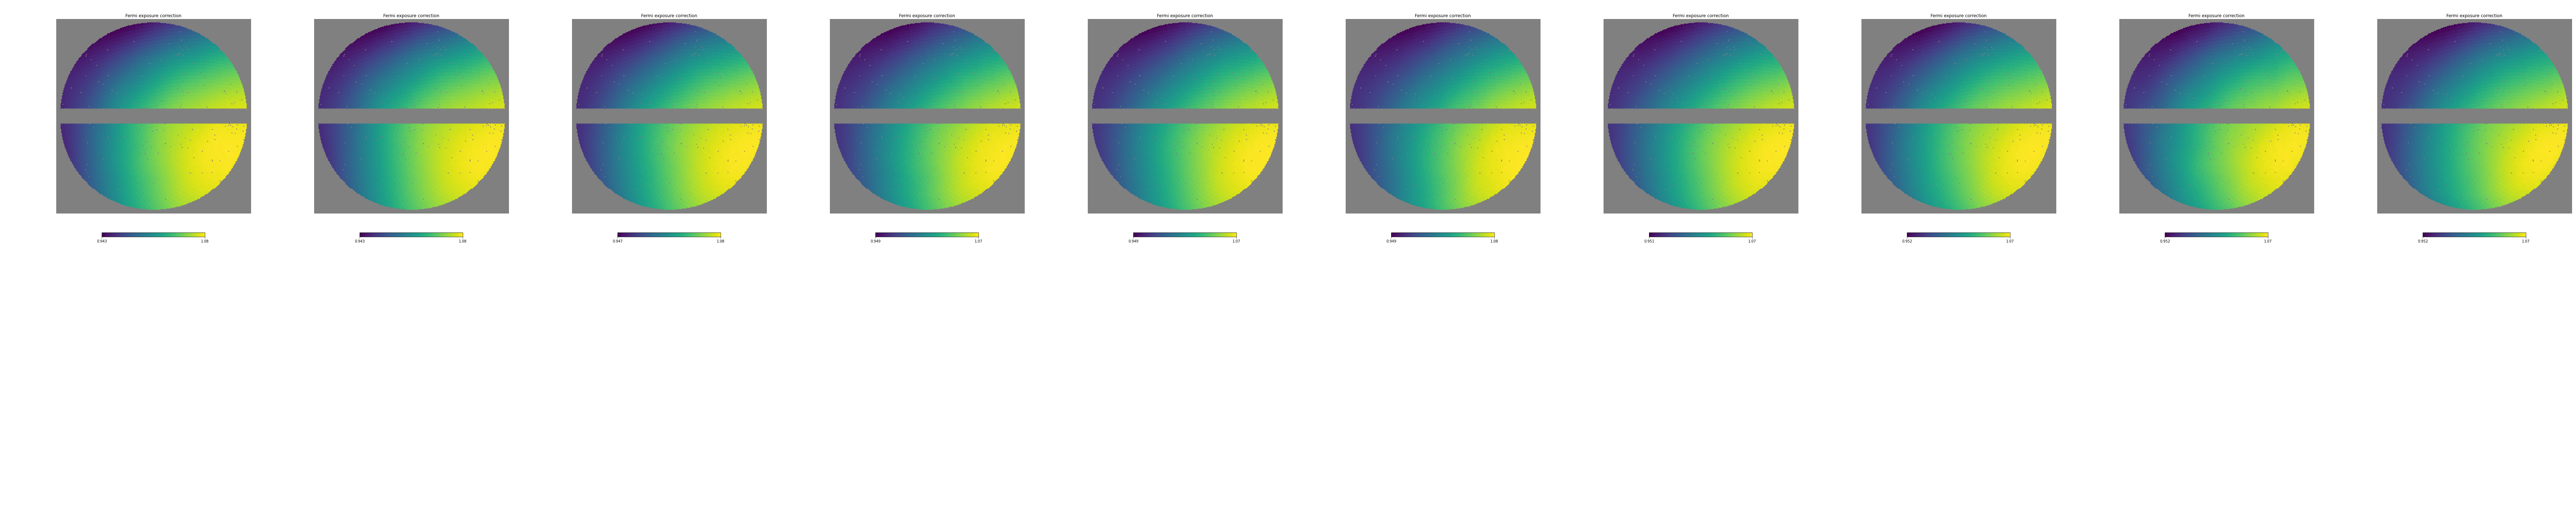

In [15]:
fig, ax= plt.subplots(2,col,figsize = (100,20))

subplot=1
[axi.set_axis_off() for axi in ax.ravel()]
plt.tight_layout()


for Ebin in range(0,len(gce.p.data["Ebins"])-1):
    hp.cartview(gce.decompress(gce.template_dict["rescale_compressed"][:,Ebin], fill_value=np.nan), nest=True,
                title="Fermi exposure correction", lonra=[-r, r], sub=(2,col,subplot), latra=[-r, r])
    subplot+=1

plt.show()

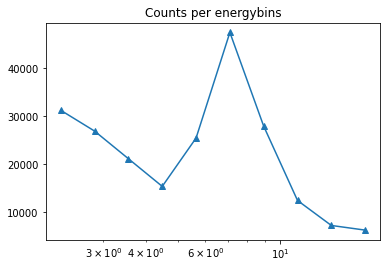

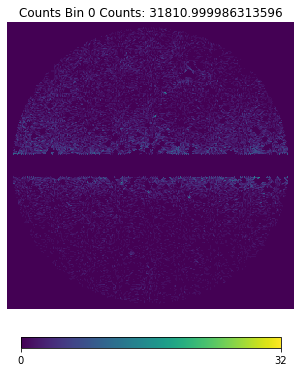

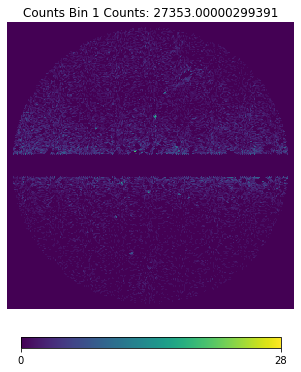

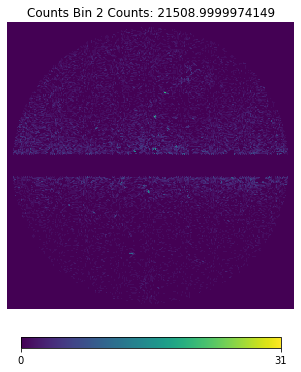

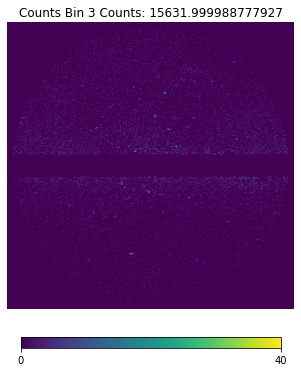

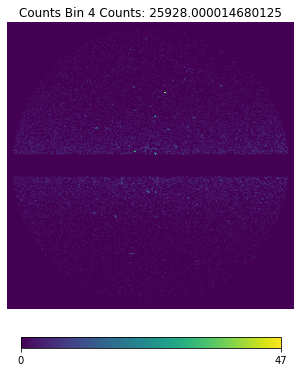

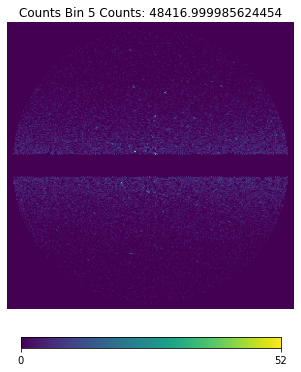

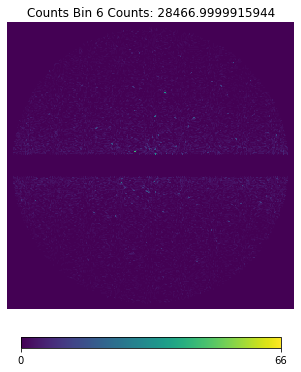

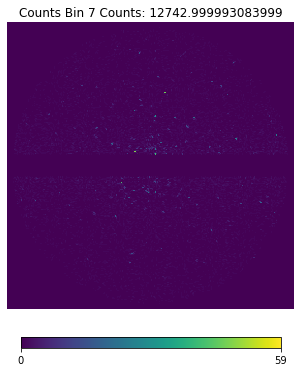

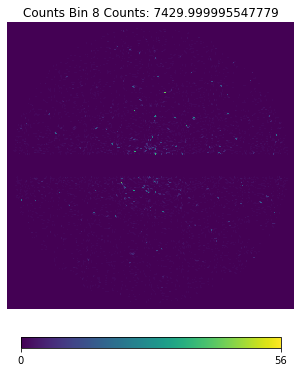

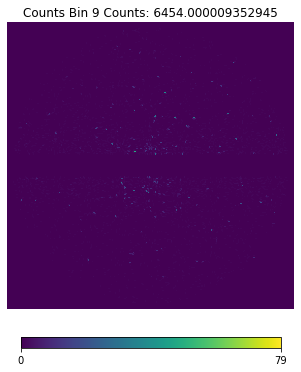

In [16]:
map_to_plot=1
gce.plot_mean_spectra(data[map_to_plot])
plt.show()


for Ebin in range(0,len(gce.p.data["Ebins"])-1):
    maps = gce.decompress(data[map_to_plot,:,Ebin] * gce.template_dict["rescale_compressed"][:,Ebin])
    hp.cartview(maps, nest=True,
                 lonra=[-r, r], latra=[-r, r], cmap= "viridis", title='Counts Bin ' + str(Ebin) + " Counts: " + str(maps.sum()))
    plt.show()

In [17]:
data_counts=data.sum(2).sum(1)
print(np.mean(data_counts))

191494.6


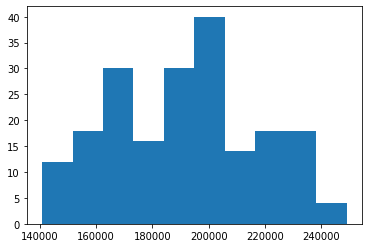

In [18]:
plt.hist(data_counts)
plt.show()

In [19]:
def get_template(fermi_folder, temp):
    """
    Returns a template.
    :param fermi_folder: folder containing the template maps
    :param temp: short name of template
    :return: template
    """
    if temp == "iso":
        t = np.load(os.path.join(fermi_folder, 'template_iso_smooth.npy'))
    elif temp == "dif":
        t = np.load(os.path.join(fermi_folder, 'template_dif.npy'))
    elif temp == "bub":
        t = np.load(os.path.join(fermi_folder, 'template_bub_smooth.npy'))
    elif temp == "bub_var":
        try:
            t = np.load(os.path.join(fermi_folder, 'template_nbub.npy'))
        except FileNotFoundError:
            t = np.load(os.path.join(fermi_folder, 'template_bub_alt.npy'))
    elif temp == "gce":
        try:
            t = np.load(os.path.join(fermi_folder, 'template_gce.npy'))
        except FileNotFoundError:
            t = np.load(os.path.join(fermi_folder, 'template_nfw_g1p0_smooth.npy'))
    elif temp == "gce_12":
        try:
            t = np.load(os.path.join(fermi_folder, 'template_gce_gamma_1.20.npy'))
        except FileNotFoundError:
            t = np.load(os.path.join(fermi_folder, 'template_nfw_g1p2_smooth.npy'))
    elif temp == "gce_12_N":
        t = np.load(os.path.join(fermi_folder, 'template_gce_gamma_1.20_N.npy'))
    elif temp == "gce_12_S":
        t = np.load(os.path.join(fermi_folder, 'template_gce_gamma_1.20_S.npy'))
    elif temp == "gce_12_PS":
        t = np.load(os.path.join(fermi_folder, 'template_nfw_g1p2.npy'))
    elif temp == "disk":
        t = np.load(os.path.join(fermi_folder, 'template_dsk.npy'))
    elif temp == "thin_disk":
        try:
            t = np.load(os.path.join(fermi_folder, 'template_disk_r_s_5_z_s_0.3.npy'))
        except FileNotFoundError:
            t = np.load(os.path.join(fermi_folder, 'template_dsk_z0p3.npy'))
    elif temp == "thin_disk_PS":
        try:
            t = np.load(os.path.join(fermi_folder, 'template_disk_r_s_5_z_s_0.3.npy'))
        except FileNotFoundError:
            t = np.load(os.path.join(fermi_folder, 'template_dsk_z0p3.npy'))
    elif temp == "thick_disk":
        try:
            t = np.load(os.path.join(fermi_folder, 'template_disk_r_s_5_z_s_1.npy'))
        except FileNotFoundError:
            t = np.load(os.path.join(fermi_folder, 'template_dsk_z1p0.npy'))

    elif temp == "dif_O_pibs":
        try:
            t = np.load(os.path.join(fermi_folder, 'ModelO_r25_q1_pibrem.npy'))
        except FileNotFoundError:
            t = np.load(os.path.join(fermi_folder, 'template_Opi.npy'))
    elif temp == "dif_O_ic":
        try:
            t = np.load(os.path.join(fermi_folder, 'ModelO_r25_q1_ics.npy'))
        except FileNotFoundError:
            t = np.load(os.path.join(fermi_folder, 'template_Oic.npy'))
    elif temp == "dif_A_pibs":
        t = np.load(os.path.join(fermi_folder, 'template_Api.npy'))
    elif temp == "dif_A_ic":
        t = np.load(os.path.join(fermi_folder, 'template_Aic.npy'))
    elif temp == "dif_F_pibs":
        t = np.load(os.path.join(fermi_folder, 'template_Fpi.npy'))
    elif temp == "dif_F_ic":
        t = np.load(os.path.join(fermi_folder, 'template_Fic.npy'))
    elif temp == "psc_3":
        try:
            t = np.load(os.path.join(fermi_folder, 'template_psc.npy'))
        except FileNotFoundError:
            t = np.load(os.path.join(fermi_folder, 'template_psc_3fgl.npy'))
    elif temp == "psc_4":
        t = np.load(os.path.join(fermi_folder, 'template_psc_4fgl.npy'))
    elif temp == "3FGL_mask":
        try:
            t = np.load(os.path.join(fermi_folder, 'fermidata_pscmask.npy'))
        except FileNotFoundError:
            t = np.load(os.path.join(fermi_folder, 'fermidata_pscmask_3fgl.npy'))
    elif temp == "4FGL_mask":
        t = np.load(os.path.join(fermi_folder, 'fermidata_pscmask_4fgl.npy'))
    elif temp == "exp":
        t = np.load(os.path.join(fermi_folder, 'fermidata_exposure.npy'))
    elif temp == "counts":
        t = np.load(os.path.join(fermi_folder, "fermidata_counts.npy"))
    elif temp == "fermi_map":
        t = np.load(os.path.join(fermi_folder, "fermidata_counts.npy"))
    else:
        raise NotImplementedError("Template", temp, "not available!")
    return t

In [20]:
fermi_data=get_template("/home/flo/GCE_NN/data/fermi_data_edep/fermi_data_256/", "fermi_map")
#TODO hist vom fermi data
#ffs in ebin

In [21]:
fermi_data.shape


(40, 786432)

In [22]:
mod_names=gce.p.mod["models_P"]+gce.p.mod["models_PS"]
print(mod_names)

['dif_O_pibs', 'dif_O_ic', 'iso', 'bub', 'gce_12_PS', 'thin_disk_PS']


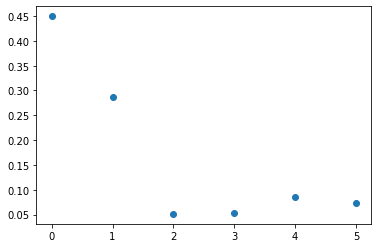

In [23]:
import pickle
data, labels = samples["data"], samples["label"]
dat=open("/home/flo/GCE_NN/data/Combined_maps/Example_comb_256/Train/Maps_0000_train.pickle", "rb")
key_data=pickle.load(dat)

mean_labels=[]
for temp in key_data["flux_fraction"].keys():
    mean_labels.append(key_data["flux_fraction"][temp].mean())

plt.scatter(range(0,6),mean_labels)
plt.show()

In [24]:
labels[0].std()


0.20781986

In [25]:
mean_labels

[0.4495658862310911,
 0.28785610246748994,
 0.05130450557806859,
 0.05377422007134251,
 0.08499716360951928,
 0.07250212204248861]

In [26]:
key_data["flux_fraction"]["bub"]

array([[5.87420746e-03, 9.62210597e-03, 1.38962709e-02, 1.80783209e-02,
        2.41912425e-02, 2.88857195e-02, 3.24102789e-02, 3.95463636e-02,
        3.68034211e-02, 3.69152239e-02],
       [3.03767229e-02, 3.02279736e-02, 2.48039726e-02, 1.98314691e-02,
        1.37706021e-02, 1.29526148e-02, 1.09028180e-02, 9.92699838e-03,
        8.87412361e-03, 7.90560965e-03],
       [1.86313577e-02, 1.66543015e-02, 1.62728249e-02, 1.78356113e-02,
        1.92972413e-02, 2.59668523e-02, 3.20475691e-02, 2.90441661e-02,
        3.27717826e-02, 2.56476905e-02],
       [4.14283674e-03, 2.95287098e-03, 2.71394974e-03, 1.83768581e-03,
        2.29973471e-03, 2.27877255e-03, 4.36785081e-03, 3.16590107e-03,
        3.73555998e-03, 3.87219259e-03],
       [0.00000000e+00, 0.00000000e+00, 1.48902508e-03, 3.52137518e-02,
        1.70299843e-01, 3.66495631e-01, 1.86735514e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
   

In [27]:
import pickle
bub=open("/home/flo/GCE_NN/data/Template_maps/Example_256/bub/Maps_19_2998.pickle", "rb")
dif_O_ic=open("/home/flo/GCE_NN/data/Template_maps/Example_256/dif_O_ic/Maps_19_2998.pickle", "rb")
dif_O_pibs=open("/home/flo/GCE_NN/data/Template_maps/Example_256/dif_O_pibs/Maps_19_2998.pickle", "rb")
iso=open("/home/flo/GCE_NN/data/Template_maps/Example_256/iso/Maps_19_2998.pickle", "rb")
thin_disk_PS=open("/home/flo/GCE_NN/data/Template_maps/Example_256/thin_disk_PS/Maps_19_2998.pickle", "rb")
gce_12_PS=open("/home/flo/GCE_NN/data/Template_maps/Example_256/gce_12_PS/Maps_19_5996.pickle", "rb")

bub=pickle.load(bub)
dif_O_ic=pickle.load(dif_O_ic)
dif_O_pibs=pickle.load(dif_O_pibs)
iso=pickle.load(iso)
thin_disk_PS=pickle.load(thin_disk_PS)
gce_12_PS=pickle.load(gce_12_PS)

[1582 1552 1446 1321 1321 1094  973  931  765  607]


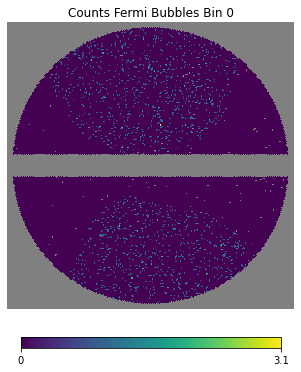

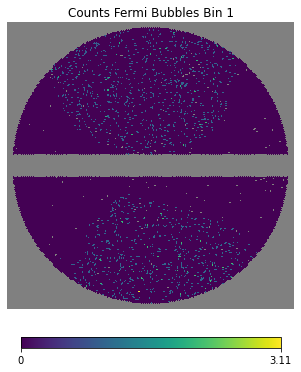

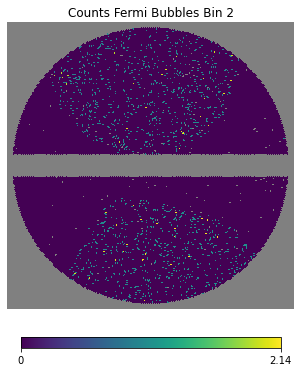

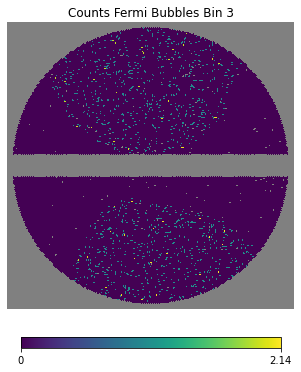

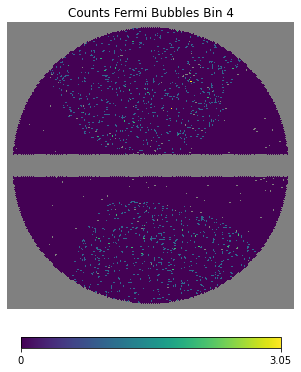

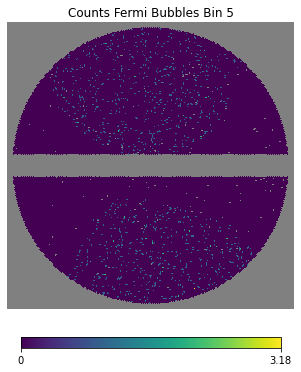

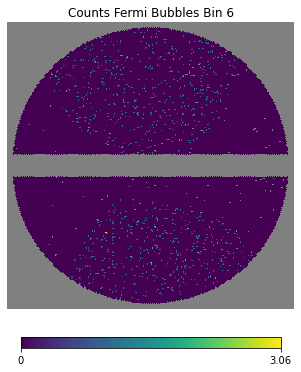

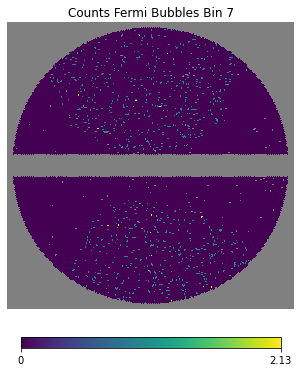

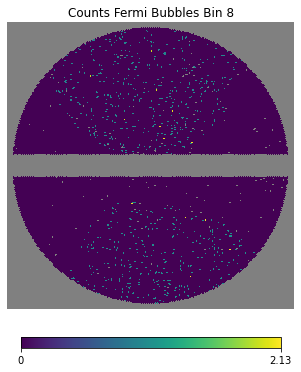

[12464 16201 19530 22048 15850  2780    57     0     0     0]


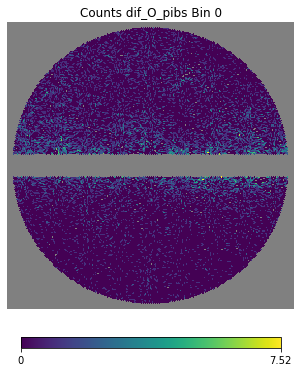

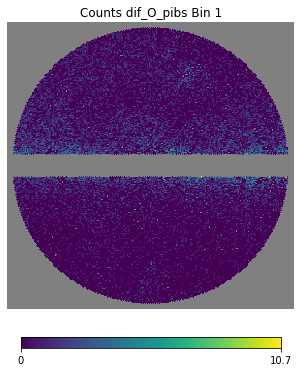

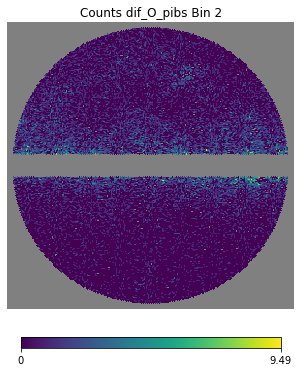

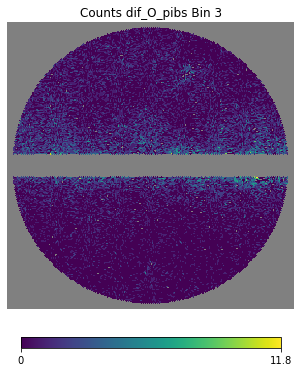

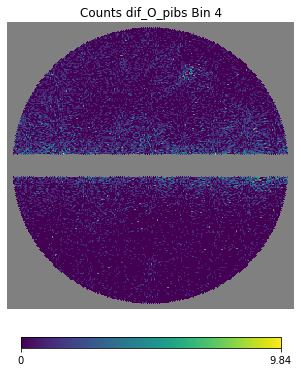

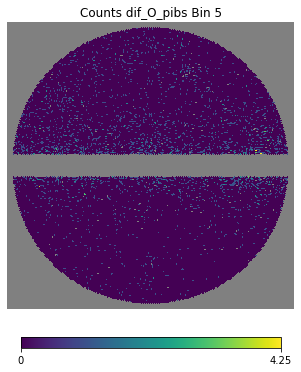

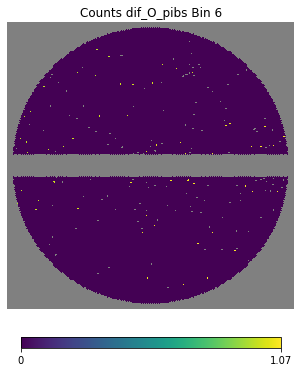

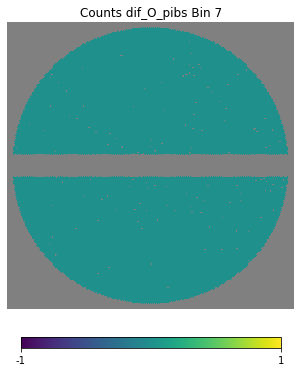

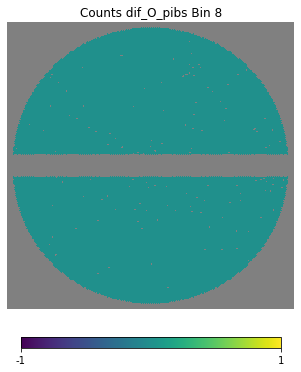

[12108 12685 12955 11845  9798  6894  3755  1779   670   180]


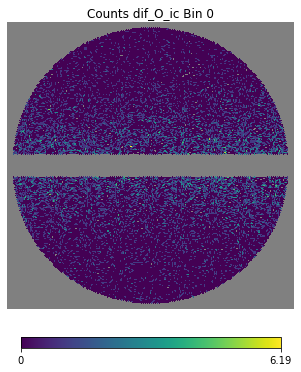

In [ ]:
maps=20
bub["data"][20].shape
names=['dif_O_pibs', 'dif_O_ic', 'iso', 'bub', 'gce_12_PS', 'thin_disk_PS']
print(bub["data"][maps].sum(0))
for ebin in range(0,9):
    hp.cartview(gce.decompress(bub["data"][maps][:,ebin] * gce.template_dict["rescale_compressed"][:,ebin], fill_value=np.nan), nest=True, lonra=[-r, r], latra=[-r, r], title='Counts Fermi Bubbles Bin ' + str(ebin))
    plt.savefig('Counts Fermi Bubbles Bin ' + str(ebin))
    plt.show()

maps=20
print(dif_O_pibs["data"][maps].sum(0))
for ebin in range(0,9):
    hp.cartview(gce.decompress(dif_O_pibs["data"][maps][:,ebin] * gce.template_dict["rescale_compressed"][:,ebin], fill_value=np.nan), nest=True, lonra=[-r, r], latra=[-r, r], title='Counts dif_O_pibs Bin ' + str(ebin))
    plt.savefig('Counts dif_O_pibs Bin ' + str(ebin))
    plt.show()

maps=20
print(dif_O_ic["data"][maps].sum(0))
for ebin in range(0,9):
    hp.cartview(gce.decompress(dif_O_ic["data"][maps][:,ebin] * gce.template_dict["rescale_compressed"][:,ebin], fill_value=np.nan), nest=True, lonra=[-r, r], latra=[-r, r], title='Counts dif_O_ic Bin ' + str(ebin))
    plt.savefig('Counts dif_O_ic Bin ' + str(ebin))
    plt.show()

maps=20
print(iso["data"][maps].sum(0))
for ebin in range(0,9):
    hp.cartview(gce.decompress(iso["data"][maps][:,ebin] * gce.template_dict["rescale_compressed"][:,ebin], fill_value=np.nan), nest=True, lonra=[-r, r], latra=[-r, r], title='Counts iso Bin ' + str(ebin))
    plt.savefig('Counts iso Bin ' + str(ebin))
    plt.show()

maps=20
print(thin_disk_PS["data"][maps].sum(0))
for ebin in range(0,9):
    hp.cartview(gce.decompress(dif_O_pibs["data"][maps][:,ebin] * gce.template_dict["rescale_compressed"][:,ebin], fill_value=np.nan), nest=True, lonra=[-r, r], latra=[-r, r], title='Counts thin_disk_PS Bin ' + str(ebin))
    plt.savefig('Counts thin_disk_PS Bin ' + str(ebin))
    plt.show()

maps=0
print(gce_12_PS["data"][maps].sum(0))
for ebin in range(0,9):
    hp.cartview(gce.decompress(gce_12_PS["data"][maps][:,ebin] * gce.template_dict["rescale_compressed"][:,ebin], fill_value=np.nan), nest=True, lonra=[-r, r], latra=[-r, r], title='Counts gce_12_PS Bin ' + str(ebin))
    plt.savefig('Counts gce_12_PS Bin ' + str(ebin))
    plt.show()